# Finetune EfficientNet


## efficientnet_1080repetitive


With 1920x1080 repetitive-padded melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnet_1080repetitive'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b0(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-3, -2, -1]:  # Use negative indices to target the last 3 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for EfficientNet-B0
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_23344\3135153334.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.61it/s, Loss=0.2142188847064972, Elapsed=31.5082s, ETA=0.0000s]  


Epoch 1 completed in 133.5729s
Train Loss: 0.9415914356019456 - Train Accuracy: 60.032563714072495
Validation Loss: 0.7663780311743419 - Validation Accuracy: 69.31194596876318

Epoch 2/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.65it/s, Loss=0.07995735108852386, Elapsed=31.5476s, ETA=0.0000s] 


Epoch 2 completed in 133.7885s
Train Loss: 0.6934566093834839 - Train Accuracy: 70.74693019153796
Validation Loss: 0.6946824051936468 - Validation Accuracy: 71.16926973406501

Epoch 3/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.66it/s, Loss=0.11496228724718094, Elapsed=31.1751s, ETA=0.0000s] 


Epoch 3 completed in 133.4171s
Train Loss: 0.5744569230114105 - Train Accuracy: 75.98878360959725
Validation Loss: 0.6772227308154106 - Validation Accuracy: 74.11355002110595

Epoch 4/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.64it/s, Loss=0.014480827376246452, Elapsed=31.8677s, ETA=0.0000s]


Epoch 4 completed in 134.2079s
Train Loss: 0.5019925685459479 - Train Accuracy: 78.72956287736595
Validation Loss: 0.6940059669564168 - Validation Accuracy: 74.17686787674124

EarlyStopping counter: 1/5
Epoch 5/50


Validating: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s, Loss=0.029588738456368446, Elapsed=52.1518s, ETA=0.0000s]


Epoch 5 completed in 213.8304s
Train Loss: 0.42274236674770455 - Train Accuracy: 81.53366047805342
Validation Loss: 0.6752315677454074 - Validation Accuracy: 77.36386661038412

Epoch 6/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.69it/s, Loss=0.02266809530556202, Elapsed=31.3015s, ETA=0.0000s]  


Epoch 6 completed in 149.0637s
Train Loss: 0.36453314353792654 - Train Accuracy: 83.83121141539088
Validation Loss: 0.7614290201912324 - Validation Accuracy: 76.94174757281553

EarlyStopping counter: 1/5
Epoch 7/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.70it/s, Loss=0.023140398785471916, Elapsed=30.9924s, ETA=0.0000s] 


Epoch 7 completed in 132.2419s
Train Loss: 0.31660221207004063 - Train Accuracy: 86.13102372176115
Validation Loss: 0.748378484621644 - Validation Accuracy: 77.57492612916842

EarlyStopping counter: 2/5
Epoch 8/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.64it/s, Loss=0.0034566200338304043, Elapsed=31.3745s, ETA=0.0000s]


Epoch 8 completed in 132.1622s
Train Loss: 0.26765381432854374 - Train Accuracy: 87.89941430542049
Validation Loss: 0.8794991357810795 - Validation Accuracy: 74.30350358801182

EarlyStopping counter: 3/5
Epoch 9/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.70it/s, Loss=0.05175713822245598, Elapsed=31.0250s, ETA=0.0000s] 


Epoch 9 completed in 131.8830s
Train Loss: 0.23294382247363213 - Train Accuracy: 89.41227018837205
Validation Loss: 0.925080224821965 - Validation Accuracy: 76.0552975939215

EarlyStopping counter: 4/5
Epoch 10/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.65it/s, Loss=0.6207920908927917, Elapsed=31.2792s, ETA=0.0000s]   

Epoch 10 completed in 132.2870s
Train Loss: 0.20224360766352256 - Train Accuracy: 90.6175798828611
Validation Loss: 0.9218103309472402 - Validation Accuracy: 77.66990291262135

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


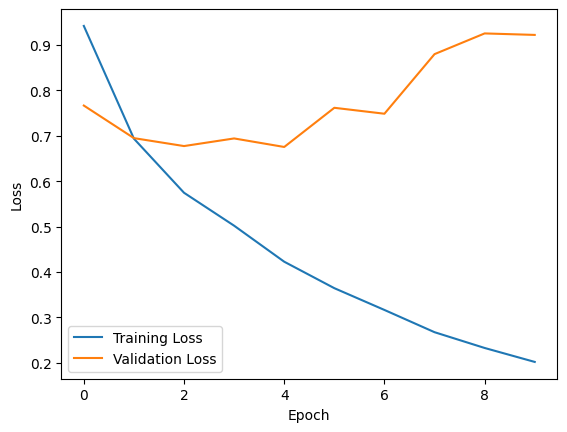

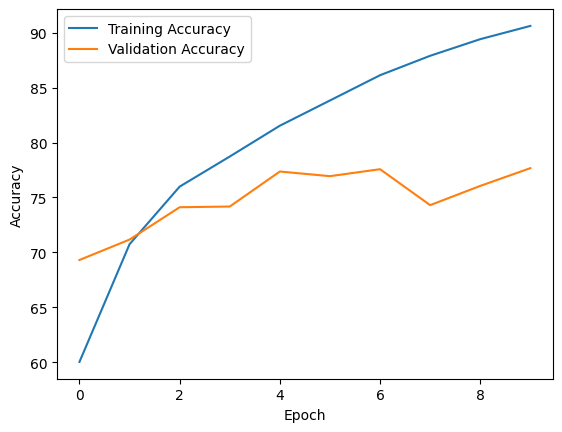

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]

Test Accuracy: 0.7711
Test Precision: 0.7821
Test Recall: 0.7711
Test F1-score: 0.7739

              precision    recall  f1-score   support

       Anger       0.78      0.80      0.79       916
       Bored       0.83      0.90      0.86      1098
     Disgust       0.46      0.72      0.56       291
        Fear       0.50      0.67      0.57       308
       Happy       0.82      0.72      0.77      1914
     Neutral       0.75      0.73      0.74      2226
    Question       0.92      0.86      0.89      1139
         Sad       0.80      0.72      0.76       857
    Surprise       0.72      0.79      0.75       728

    accuracy                           0.77      9477
   macro avg       0.73      0.77      0.74      9477
weighted avg       0.78      0.77      0.77      9477



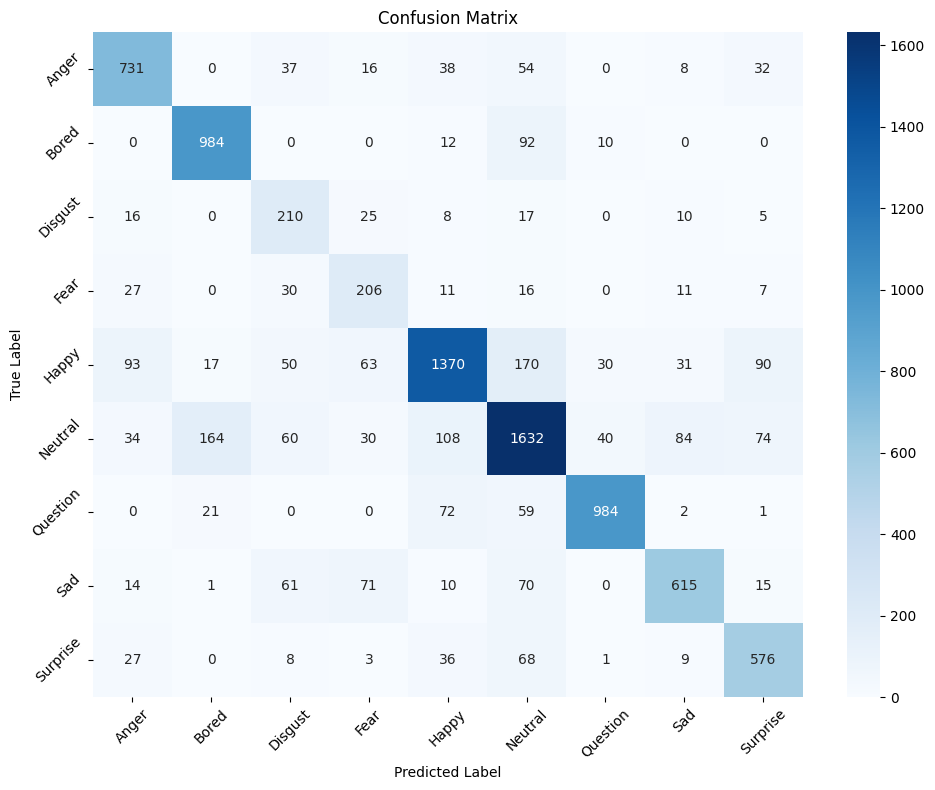

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)